# Visualization

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict

## RQ1. Distribution of Distribution of Incorrect Coreference

In [22]:
issue_types = ['EE', 'ME', 'MM', 'EM', 'CE', 'SE']
genMethodNameList = ['SIT', 'PatInv', 'CAT', 'Crest']
source_cnt = defaultdict(lambda: defaultdict(int))

oriBug_list, newBug_list, bothBug_list, correct_list = [], [], [], []

# Note that we combine
for genMethod in genMethodNameList:
    file = '../Output/RQ1-IssueRevealing/label/FurtherAnalysisOnDistribution/{}.txt'.format(genMethod)

    oriBug, newBug, bothBug, correct = 0, 0, 0, 0
    content = open(file).readlines()

    cnt = 0
    oriResult, newResult = None, None
    for line in content:
        if oriResult is not None and newResult is not None:
            if oriResult == True and newResult == True:
                bothBug += 1
            elif oriResult == True and newResult == False:
                oriBug += 1
            elif oriResult == False and newResult == True:
                newBug += 1
            else:
                correct += 1
            oriResult, newResult = None, None

        if line.startswith('oriBuggy:'):
            result = line.strip().split(': ')[1]
            oriResult = True if result != 'N' else False
        if line.startswith('newBuggy:'):
            result = line.strip().split(': ')[1]
            newResult = True if result != 'N' else False

    oriBug_list.append(oriBug)
    newBug_list.append(newBug)
    bothBug_list.append(bothBug)
    correct_list.append(correct)

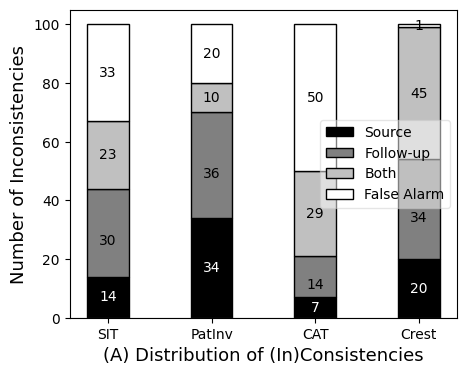

In [24]:
N = 4

level_1 = oriBug_list
level_2 = [x + y for x, y in zip(level_1, newBug_list)]
level_3 = [x + y for x, y in zip(level_2, bothBug_list)]

ind = np.arange(N)  # the x locations for the groups
width = 0.4  # the width of the bars: can also be len(x) sequence

plt.rcdefaults()
fig = plt.figure(figsize=(5, 4))

ax = fig.add_subplot(1, 1, 1)
labels = ['Source', 'Follow-up', 'Both', 'False Alarm']

p1 = ax.bar(ind, oriBug_list, width, tick_label=genMethodNameList, label=labels[0], color='black', ec='black')
p2 = ax.bar(ind, newBug_list, width,
            bottom=level_1, label=labels[1], color='gray', ec='black')  # lavender
p3 = ax.bar(ind, bothBug_list, width,
            bottom=level_2, label=labels[2], color='silver', ec='black')  # lavender
p4 = ax.bar(ind, correct_list, width,
            bottom=level_3, label=labels[3], color='white', ec='black')  # lavender

ax.axhline(0, color='gray', linewidth=0.8)

ax.set_xlabel('(A) Distribution of (In)Consistencies', fontsize=13)
ax.set_ylabel('Number of Inconsistencies', fontsize=13)
ax.legend(loc='right', framealpha=0.5)

# Label with label_type 'center' instead of the default 'edge'
ax.bar_label(p1, label_type='center',color='white')
ax.bar_label(p2, label_type='center', padding=-6)
ax.bar_label(p3, label_type='center')
ax.bar_label(p4, label_type='center')

plt.xticks()

# plt.show()
plt.savefig('../Figure/rq1-distribution.png')

### RQ2. Test Quality

The number of follow-up inputs that preserve/change the coreference of the source input


In [3]:
# Read files and count

genMethodNameList = ['SIT', 'PatInv', 'CAT', 'Crest']

changed = []

for genMethod in genMethodNameList:
    file = '../Output/RQ2-Quality/label/label100_{}.txt'.format(genMethod)
    lines = open(file).readlines()
    cur_change_cnt = 0

    for lid, line in enumerate(lines, 1):
        if line.startswith('CorefChanged:'):
            result = line.strip().split(': ')[1]
            if result == 'True':
                cur_change_cnt += 1
            elif result == 'False':
                continue
            else:
                print('Method: {}, line: {}. Expected: True/False. Got: {}'.format(genMethod, lid, result))
                raise ValueError('Incorrect labeling is found!')
    changed.append(cur_change_cnt)

# To check:
assert len(changed) == len(genMethodNameList)
for name, num in zip(genMethodNameList, changed):
    print("{}: {}".format(name, num))

SIT: 52
PatInv: 25
CAT: 43
Crest: 2


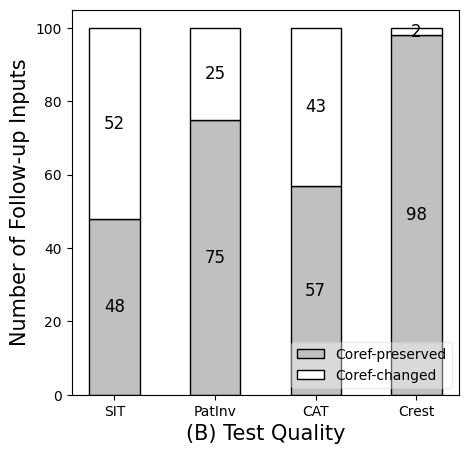

In [25]:
# Draw

N = len(genMethodNameList)

preserved = [100 - x for x in changed]
ind = np.arange(N)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence

plt.rcdefaults()
fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot(1, 1, 1)
labels = ['Coref-preserved', 'Coref-changed']

p1 = ax.bar(ind, preserved, width, tick_label=genMethodNameList, label=labels[0], color='silver', ec='black')
p2 = ax.bar(ind, changed, width,
            bottom=preserved, label=labels[1], color='white', ec='black')  # lavender

ax.axhline(0, color='gray', linewidth=0.8)

ax.set_ylabel('Number of Follow-up Inputs', fontsize=15)
ax.set_xlabel('(B) Test Quality', fontsize=15)
ax.legend(loc='lower right', framealpha=0.4)


# Label with label_type 'center' instead of the default 'edge'
ax.bar_label(p1, label_type='center',fontsize=12)
ax.bar_label(p2, label_type='center',fontsize=12)

plt.savefig('../Figure/rq2-quality.png')

## RQ2. Test Quality - Semantic Similarity

In [5]:
# Read and count

genMethodNameList = ['SIT', 'PatInv', 'CAT', 'Crest']
metrics = ['semSim', 'natDiff']

genMethod = genMethodNameList[0]

# Visualize all
df_all = None
for genMethod in genMethodNameList:
    df = pd.read_csv('../Output/RQ2-Quality/similarity/Eval_Sem_Nat_{}.tsv'.format(genMethod), delimiter='\t')
    if df_all is None:
        df_all = df
    else:
        df_all = pd.concat([df_all, df], axis=0)


df = df_all
data = []
for metric in metrics:
    y1 = df[df['CorefChanged']][metric].values
    y2 = df[df['CorefChanged'] == False][metric].values
    data.append((y1, y2))

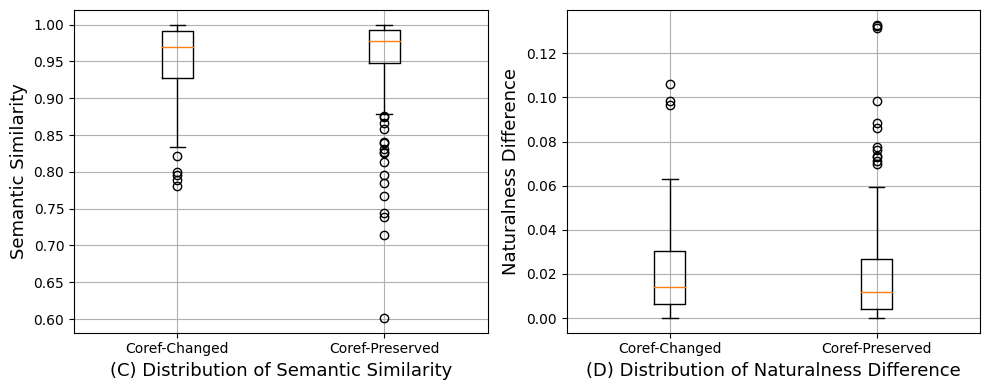

In [26]:
# Draw


fig = plt.figure(figsize=(10, 4))
plt.rcdefaults()

title = ['Semantic Similarity', 'Naturalness Difference']
xtitle = ['(C) Distribution of Semantic Similarity', '(D) Distribution of Naturalness Difference']

for ti, title in enumerate(title, 1):
    ax1 = fig.add_subplot(1, 2, ti)

    ax1.boxplot(data[ti-1])

    ax1.grid()
    ax1.set_xscale('linear') # 'log'
    ax1.set_xlabel(xtitle[ti-1], fontsize = 13)
    ax1.set_ylabel(title, fontsize = 13
                   )
    plt.setp(ax1, xticks=[1.0, 2.0], xticklabels=['Coref-Changed', 'Coref-Preserved'])


plt.tight_layout()
plt.savefig('../Figure/rq2-similarity.png'.format(genMethod))

## RQ3. Distribution of Issue Types

In [7]:
issue_types = ['EE', 'ME', 'MM', 'EM', 'CE', 'SE']

type_cnt = defaultdict(lambda: defaultdict(int))

for genMethod in genMethodNameList:
    file = '../Output/RQ3-IssueType/label/{}.txt'.format(genMethod)
    content = open(file).readlines()
    for line in content:
        if line.startswith('oriBuggy: ') or line.startswith('newBuggy: '):
            result = line.strip().split(': ')[1]
            if result != 'N':
                type_set = result.split(', ')
                for t in type_set:
                    type_cnt[genMethod][t] += 1

# For debug
for genMethod in genMethodNameList:
    print(genMethod)
    for key, val in type_cnt[genMethod].items():
        print("{}: {}".format(key, val))
    print()

SIT
SE: 7
MM: 42
EM: 40
EE: 12
ME: 25

PatInv
MM: 42
EM: 33
ME: 29
EE: 7
SE: 10

CAT
EE: 11
EM: 47
MM: 44
SE: 14
ME: 26
CE: 2

Crest
SE: 36
ME: 27
EE: 47
CE: 26
EM: 33
MM: 46



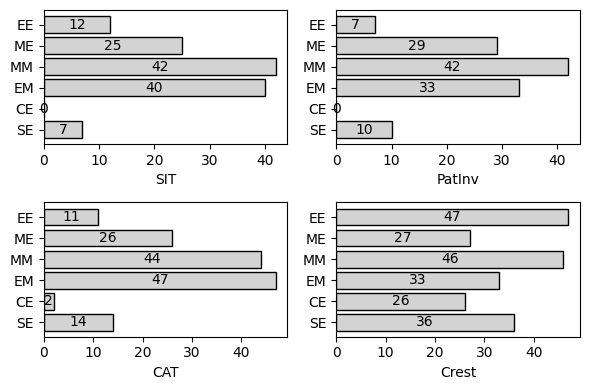

In [27]:
# Draw

plt.rcdefaults()
fig = plt.figure(figsize=(6, 4))

for i, genMethod in enumerate(genMethodNameList, 1):
    ax = fig.add_subplot(2, 2, i)

    y_pos = np.arange(len(type_cnt[genMethod]))
    x_values = []
    x_labels = []

    for t in issue_types:
        x_labels.append(t)
        x_values.append(type_cnt[genMethod][t])

    p1 = ax.barh(y_pos, x_values, height=0.8, align='center', color='lightgray', ec='black')
    ax.set_yticks(y_pos, labels=x_labels)
    ax.bar_label(p1, label_type='center')

    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel(genMethod)
plt.tight_layout()

# plt.show()
plt.savefig('../Figure/rq3-issue_type.png')

### RQ4. Threshold Selection (Max Number)

In [30]:
# For each source input, generate at most maxnum follow-up inputs

all_list = []
issue_list = []

df = pd.read_csv('../Output/RQ1-IssueRevealing/generate/Crest.tsv', delimiter='\t')

ind_range = range(1, 101, 5)

for maxnum in ind_range:
    print("maxnum = ", maxnum)
    all = 0
    issue = 0
    for i in set(df['OID']):
        df1 = df[(df['OID'] == i)]
        df1 = df1.sample(n=min(len(df1), maxnum), random_state=1)
        assert len(df1) <= maxnum
        all += len(df1)
        issue += len(df1[(df1['pairConsistent'] == False)])
    print(genMethod, len(set(df['OID'])), all, issue)
    print()
    all_list.append(all)
    issue_list.append(issue)

maxnum =  1
Crest 196 196 35

maxnum =  6
Crest 196 1135 184

maxnum =  11
Crest 196 1980 323

maxnum =  16
Crest 196 2701 440

maxnum =  21
Crest 196 3182 529

maxnum =  26
Crest 196 3182 529

maxnum =  31
Crest 196 3182 529

maxnum =  36
Crest 196 3182 529

maxnum =  41
Crest 196 3182 529

maxnum =  46
Crest 196 3182 529

maxnum =  51
Crest 196 3182 529

maxnum =  56
Crest 196 3182 529

maxnum =  61
Crest 196 3182 529

maxnum =  66
Crest 196 3182 529

maxnum =  71
Crest 196 3182 529

maxnum =  76
Crest 196 3182 529

maxnum =  81
Crest 196 3182 529

maxnum =  86
Crest 196 3182 529

maxnum =  91
Crest 196 3182 529

maxnum =  96
Crest 196 3182 529



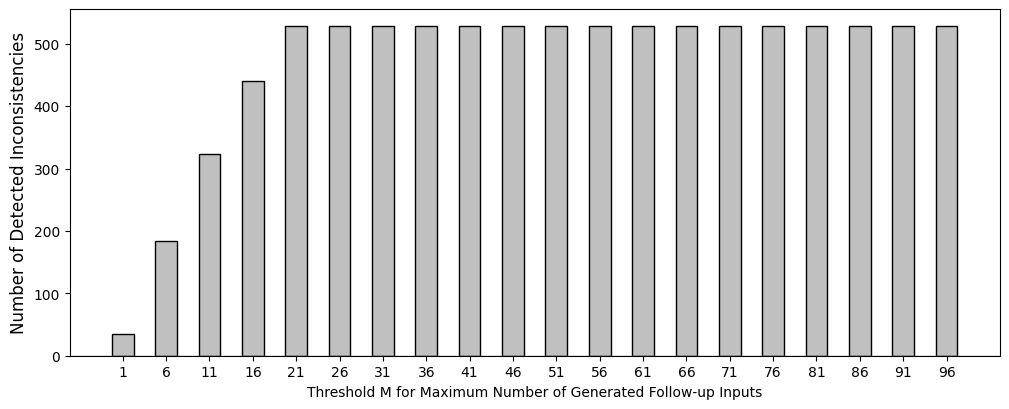

In [31]:
N = len(issue_list)
issue_tuple = issue_list
top_tuple = [x - y for x, y in zip(all_list, issue_list)]

ind = np.arange(N)  # the x locations for the groups
width = 0.5  # the width of the bars: can also be len(x) sequence

fig = plt.figure(figsize=(12, 4.5))
plt.rcdefaults()
ax = fig.add_subplot(1, 1, 1)
labels = ['Detected Inconsistencies', 'Generated']

p1 = ax.bar(ind, issue_tuple, width, tick_label=[x for x in ind_range], label=labels[0], color='silver', ec='black')

ax.axhline(0, color='grey', linewidth=1.0)

ax.set_xlabel('Threshold M for Maximum Number of Generated Follow-up Inputs', fontsize=10)
ax.set_ylabel('Number of Detected Inconsistencies', fontsize=12)


# plt.show()
plt.savefig('../Figure/rq4-threshold_M.png')

## RQ4. Exploration - Impact of BLANC precision and recall to Inconsistency detection

In [17]:
# thr_p

df = pd.read_csv('../Output/RQ4-Parameter/sample/sampled200_labeled.tsv', delimiter='\t')

ind_range = range(100, 0, -1)

TP_list_thr_p, FP_list_thr_p = [], []
precision_thr_p_list = []


for thr in ind_range:
    # when drop thr_p, keep thr_r remained to be 100%
    TP = len(df[((df['pairPrecision'] < thr) | (df['pairRecall'] < 100)) & (df['isBuggy'] == True)])
    FP = len(df[((df['pairPrecision'] < thr) | (df['pairRecall'] < 100)) & (df['isBuggy'] == False)])
    TN = len(df[((df['pairPrecision'] >= thr) & (df['pairRecall'] >= 100)) & (df['isBuggy'] == False)])
    FN = len(df[((df['pairPrecision'] >= thr) & (df['pairRecall'] >= 100)) & (df['isBuggy'] == True)])

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    TP_list_thr_p.append(TP)
    FP_list_thr_p.append(FP)

    precision_thr_p_list.append(precision)
    # for debugging
    print('thr = ', thr)
    print('TP = {} | FP = {} | TN = {} | FN = {}'.format(TP, FP, TN, FN))
    print('Precision = {} | Recall = {}'.format(precision, recall))

thr =  100
TP = 38 | FP = 1 | TN = 120 | FN = 41
Precision = 0.9743589743589743 | Recall = 0.4810126582278481
thr =  99
TP = 38 | FP = 1 | TN = 120 | FN = 41
Precision = 0.9743589743589743 | Recall = 0.4810126582278481
thr =  98
TP = 38 | FP = 1 | TN = 120 | FN = 41
Precision = 0.9743589743589743 | Recall = 0.4810126582278481
thr =  97
TP = 38 | FP = 1 | TN = 120 | FN = 41
Precision = 0.9743589743589743 | Recall = 0.4810126582278481
thr =  96
TP = 38 | FP = 1 | TN = 120 | FN = 41
Precision = 0.9743589743589743 | Recall = 0.4810126582278481
thr =  95
TP = 38 | FP = 1 | TN = 120 | FN = 41
Precision = 0.9743589743589743 | Recall = 0.4810126582278481
thr =  94
TP = 38 | FP = 1 | TN = 120 | FN = 41
Precision = 0.9743589743589743 | Recall = 0.4810126582278481
thr =  93
TP = 38 | FP = 1 | TN = 120 | FN = 41
Precision = 0.9743589743589743 | Recall = 0.4810126582278481
thr =  92
TP = 38 | FP = 1 | TN = 120 | FN = 41
Precision = 0.9743589743589743 | Recall = 0.4810126582278481
thr =  91
TP = 38 

In [18]:
# thr_r

ind_range = range(100, 0, -1)

TP_list_thr_r, FP_list_thr_r = [], []
precision_thr_r_list = []

for thr in ind_range:
    TP = len(df[((df['pairPrecision'] < 100) | (df['pairRecall'] < thr)) & (df['isBuggy'] == True)])
    FP = len(df[((df['pairPrecision'] < 100) | (df['pairRecall'] < thr)) & (df['isBuggy'] == False)])
    TN = len(df[((df['pairPrecision'] >= 100) & (df['pairRecall'] >= thr)) & (df['isBuggy'] == False)])
    FN = len(df[((df['pairPrecision'] >= 100) & (df['pairRecall'] >= thr)) & (df['isBuggy'] == True)])

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    TP_list_thr_r.append(TP)
    FP_list_thr_r.append(FP)

    precision_thr_r_list.append(precision)
    # for debugging
    print('thr = ', thr)
    print('TP = {} | FP = {} | TN = {} | FN = {}'.format(TP, FP, TN, FN))
    print('Precision = {} | Recall = {}'.format(precision, recall))

thr =  100
TP = 38 | FP = 1 | TN = 120 | FN = 41
Precision = 0.9743589743589743 | Recall = 0.4810126582278481
thr =  99
TP = 38 | FP = 1 | TN = 120 | FN = 41
Precision = 0.9743589743589743 | Recall = 0.4810126582278481
thr =  98
TP = 38 | FP = 1 | TN = 120 | FN = 41
Precision = 0.9743589743589743 | Recall = 0.4810126582278481
thr =  97
TP = 38 | FP = 1 | TN = 120 | FN = 41
Precision = 0.9743589743589743 | Recall = 0.4810126582278481
thr =  96
TP = 38 | FP = 1 | TN = 120 | FN = 41
Precision = 0.9743589743589743 | Recall = 0.4810126582278481
thr =  95
TP = 38 | FP = 1 | TN = 120 | FN = 41
Precision = 0.9743589743589743 | Recall = 0.4810126582278481
thr =  94
TP = 38 | FP = 1 | TN = 120 | FN = 41
Precision = 0.9743589743589743 | Recall = 0.4810126582278481
thr =  93
TP = 38 | FP = 1 | TN = 120 | FN = 41
Precision = 0.9743589743589743 | Recall = 0.4810126582278481
thr =  92
TP = 38 | FP = 1 | TN = 120 | FN = 41
Precision = 0.9743589743589743 | Recall = 0.4810126582278481
thr =  91
TP = 38 

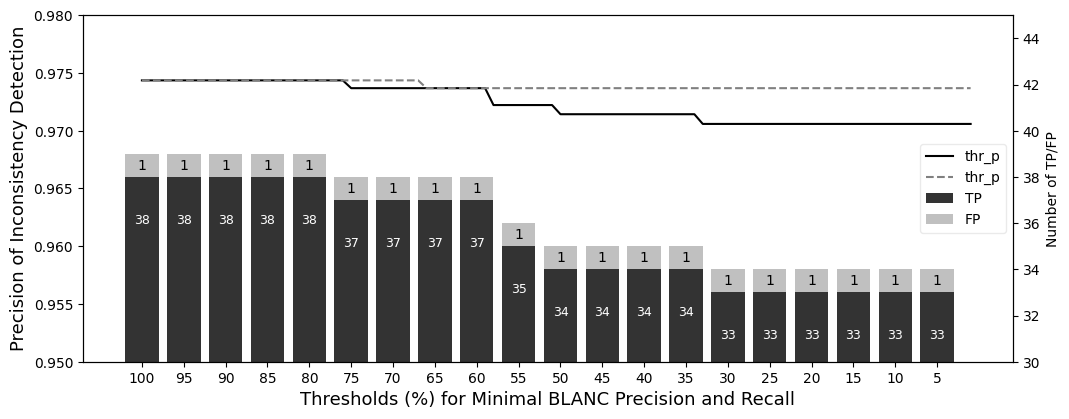

In [29]:
ind = range(1, 101, 1)  # the x locations for the groups
start_ind = 0
interval_bar = 5
bar_width = 4

fig = plt.figure(figsize=(12, 4.5))
ax = fig.add_subplot(1, 1, 1)
labels = ['thr_p', 'thr_p']

lg1 = ax.plot(ind, precision_thr_p_list[:], '-', label=labels[0], color='black')
lg2 = ax.plot(ind, precision_thr_r_list[:], '--', label=labels[1], color='gray')

plt.ylim([0.95, 0.98])

ax_r = ax.twinx()

p1 = ax_r.bar(ind[::interval_bar], TP_list_thr_p[::interval_bar], width=bar_width, label='TP'
         , color='black'
         , alpha = 0.8
         )

p2 = ax_r.bar(ind[::interval_bar], FP_list_thr_p[::interval_bar], width=bar_width, label='FP'
         , color='silver'
         , bottom=TP_list_thr_p[::interval_bar]
         , alpha = 1.0
         )

plt.ylim([30, 45])


lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax_r.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='center right', framealpha=0.4)

ax.set_xlabel('Thresholds (%) for Minimal BLANC Precision and Recall', fontsize=13)
ax.set_ylabel('Precision of Inconsistency Detection', fontsize=13)
ax_r.set_ylabel('Number of TP/FP')

ax_r.bar_label(p1, label_type='edge', labels=TP_list_thr_p[::interval_bar], padding=-35.8, fontsize=9, color='white')
ax_r.bar_label(p2, label_type='center', labels=FP_list_thr_p[::interval_bar])

plt.setp(ax_r, xticks=ind[::interval_bar], xticklabels=[str(x) for x in ind[::-interval_bar]])

# plt.show()
plt.savefig('../Figure/rq4-thresholds.png')